<a href="https://colab.research.google.com/github/guimarczewski/From-Data-to-Insights-with-Google-Cloud/blob/main/4_Creating_Permanent_Tables_and_Access_Controlled_Views_in_BigQuery.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Creating Permanent Tables and Access-Controlled Views in BigQuery

###Criando um novo conjunto de dados para armazenar as tabelas

No BigQuery, clicaremos no nome do projeto e em CREATE DATASET. No campo ID do conjunto de dados, inseriremos "ecommerce". As outras opções ficarão com seus valores padrão (Data Location, Default table Expiration). Para finalizar a criação, basta clicar em "CREATE DATASET".

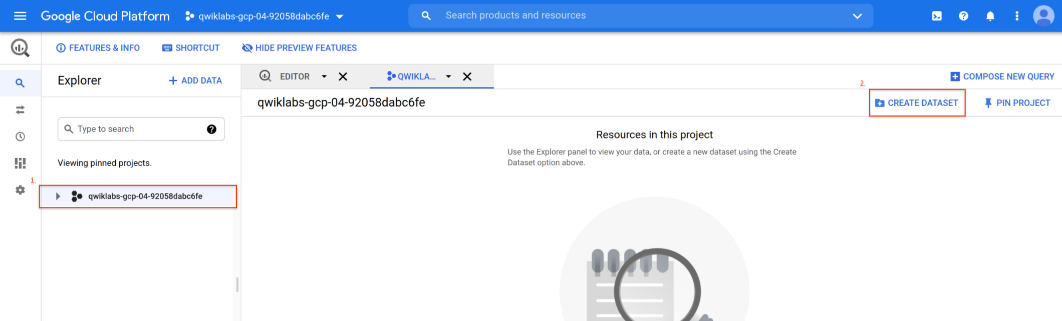

###Solucionando problemas de instruções CREATE TABLE

Regras para criar tabelas no BigQuery:
*  A lista de colunas especificada ou as colunas inferidas de uma query_statement (ou ambas) devem estar presentes.
*  Quando a lista de colunas e a cláusula as query_statement estão presentes, o BigQuery ignora os nomes na cláusula query_statement e faz a correspondência das colunas com a lista de colunas por posição.
*  Quando a cláusula as query_statement está presente e a lista de colunas está ausente, o BigQuery determina os nomes e os tipos de coluna da cláusula query_statement.
*  Os nomes das colunas devem ser especificados por meio da lista de colunas ou como cláusula query_statement.
*  Nomes de coluna duplicados não são permitidos.

Seguem alguns exemplos que estão de acordo com as diretrizes de criação de tabelas:


In [ ]:
#standardSQL
# copy one day of ecommerce data to explore
CREATE OR REPLACE TABLE ecommerce.all_sessions_raw_20170801
#schema
(
  fullVisitorId STRING OPTIONS(description="Unique visitor ID"),
  channelGrouping STRING OPTIONS(description="Channel e.g. Direct, Organic, Referral...")
)
 OPTIONS(
   description="Raw data from analyst team into our dataset for 08/01/2017"
 ) AS
 SELECT fullVisitorId, city FROM `data-to-insights.ecommerce.all_sessions_raw`
 WHERE date = '20170801'  #56,989 records
;

In [ ]:
#standardSQL
# copy one day of ecommerce data to explore
CREATE OR REPLACE TABLE ecommerce.all_sessions_raw_20170801
#schema
(
  fullVisitorId STRING NOT NULL OPTIONS(description="Unique visitor ID"),
  channelGrouping STRING NOT NULL OPTIONS(description="Channel e.g. Direct, Organic, Referral..."),
  totalTransactionRevenue INT64 NOT NULL OPTIONS(description="Revenue * 10^6 for the transaction")
)
 OPTIONS(
   description="Raw data from analyst team into our dataset for 08/01/2017"
 ) AS
 SELECT fullVisitorId, channelGrouping, totalTransactionRevenue FROM `data-to-insights.ecommerce.all_sessions_raw`
 WHERE date = '20170801'  #56,989 records
;

Agora iremos criar uma nova tabela permanente que armazene todas as transações com receita de 1º de agosto de 2017, da tabela `data-to-insights.ecommerce.all_sessions_raw`, de acordo com as seguintes regras:

* Nome da tabela deve ser Revenue_transactions_20170801. Substitua a tabela se ela já existir.

* Obtenha seus dados brutos da tabela data-to-insights.ecommerce.all_sessions_raw.

* Divida o campo de receita por 1.000.000 e armazene-o como FLOAT64 em vez de INTEGER.

* Inclua apenas transações com receita em sua tabela final.

* Incluir apenas transações em 20170801.

* Inclua estes campos:

* fullVisitorId como um campo de string OBRIGATÓRIO.

* visitId como um campo de string OBRIGATÓRIO.

* channelGrouping como um campo de string OBRIGATÓRIO.

* totalTransactionRevenue como um campo FLOAT64.

* Adicione descrições curtas para os quatro campos acima consultando o [schema](https://https://support.google.com/analytics/answer/3437719?hl=en).

* Certifique-se de desduplicar registros que tenham o mesmo fullVisitorIde visitId.

In [ ]:
#standardSQL
# copy one day of ecommerce data to explore
CREATE OR REPLACE TABLE ecommerce.revenue_transactions_20170801
#schema
(
  fullVisitorId STRING NOT NULL OPTIONS(description="Unique visitor ID"),
  visitId STRING NOT NULL OPTIONS(description="ID of the session, not unique across all users"),
  channelGrouping STRING NOT NULL OPTIONS(description="Channel e.g. Direct, Organic, Referral..."),
  totalTransactionRevenue FLOAT64 NOT NULL OPTIONS(description="Revenue for the transaction")
)
 OPTIONS(
   description="Revenue transactions for 08/01/2017"
 ) AS
 SELECT DISTINCT
  fullVisitorId,
  CAST(visitId AS STRING) AS visitId,
  channelGrouping,
  totalTransactionRevenue / 1000000 AS totalTransactionRevenue
 FROM `data-to-insights.ecommerce.all_sessions_raw`
 WHERE date = '20170801'
      AND totalTransactionRevenue IS NOT NULL #XX transactions
;

Abaixo podemos confirmar que a nova tabela está de acordo com as solicitações:

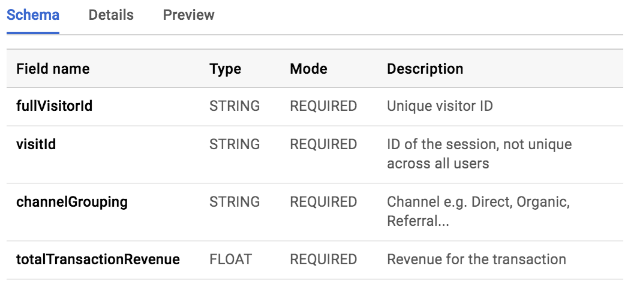

###Criando visualizações

As visualizações são consultas salvas que são executadas sempre que a visualização é chamada. No BigQuery, as visualizações são lógicas e não materializadas. Apenas a consulta é armazenada como parte da exibição - não os dados subjacentes.

Consultando as últimas 100 transações:


In [ ]:
#standardSQL
SELECT DISTINCT
  date,
  fullVisitorId,
  CAST(visitId AS STRING) AS visitId,
  channelGrouping,
  totalTransactionRevenue / 1000000 AS totalTransactionRevenue
 FROM `data-to-insights.ecommerce.all_sessions_raw`
 WHERE totalTransactionRevenue IS NOT NULL
 ORDER BY date DESC # latest transactions
 LIMIT 100
;

Para economizar tempo e permitir uma melhor organização e colaboração, podemos salvar as consultas de relatórios comuns como visualizações, conforme demonstrado abaixo:

In [ ]:
#standardSQL
CREATE OR REPLACE VIEW ecommerce.vw_latest_transactions
AS
SELECT DISTINCT
  date,
  fullVisitorId,
  CAST(visitId AS STRING) AS visitId,
  channelGrouping,
  totalTransactionRevenue / 1000000 AS totalTransactionRevenue
 FROM `data-to-insights.ecommerce.all_sessions_raw`
 WHERE totalTransactionRevenue IS NOT NULL
 ORDER BY date DESC # latest transactions
 LIMIT 100
;

Muitas vezes é difícil saber se você está selecionando ou não de uma Tabela ou de uma Visão apenas olhando o nome. Uma convenção simples é prefixar o nome da visualização com vw_ou adicionar um sufixo como _vw ou _view.

Também podemos fornecer uma descrição e rótulos à sua visualização usando OPTIONS.

In [ ]:
#standardSQL
CREATE OR REPLACE VIEW ecommerce.vw_latest_transactions
OPTIONS(
  description="latest 100 ecommerce transactions",
  labels=[('report_type','operational')]
)
AS
SELECT DISTINCT
  date,
  fullVisitorId,
  CAST(visitId AS STRING) AS visitId,
  channelGrouping,
  totalTransactionRevenue / 1000000 AS totalTransactionRevenue
 FROM `data-to-insights.ecommerce.all_sessions_raw`
 WHERE totalTransactionRevenue IS NOT NULL
 ORDER BY date DESC # latest transactions
 LIMIT 100
;

Agora criaremos um relatório que liste as 10 transações mais recentes com um valor de pedido igual ou superior a 1.000 para que sejam revisadas manualmente, conforme solicitação da equipe antifraude.

Conforme solicitado, precisamos seguir as seguintes diretrizes:

* Crie uma nova visualização em seu conjunto de dados de comércio eletrônico intitulada "vw_large_transactions". Substitua a exibição se ela já existir.

* Dê à visualização uma descrição "grandes transações para revisão".

* Dê à visualização um rótulo [("org_unit", "loss_prevention")].

* Obtenha seus dados brutos da data-to-insights.ecommerce.all_sessions_rawtabela.

* Divida o campo de receita por 1.000.000.

* Incluir apenas transações com receita maior ou igual a 1.000

* Incluir apenas transações em ou após 20170101 ordenadas pela mais recente primeiro.

* Incluir apenas currencyCode = 'USD'.

* Certifique-se de desduplicar registros.

Retorne estes campos:

* encontro
* fullVisitorId
* visitId
* Agrupamento de canais
* receita totalTransactionRevenue AS
* Código da moeda
* v2NomeDoProduto



In [ ]:
#standardSQL
CREATE OR REPLACE VIEW ecommerce.vw_large_transactions
OPTIONS(
  description="large transactions for review",
  labels=[('org_unit','loss_prevention')]
)
AS
SELECT DISTINCT
  date,
  fullVisitorId,
  visitId,
  channelGrouping,
  totalTransactionRevenue / 1000000 AS revenue,
  currencyCode
  #v2ProductName
 FROM `data-to-insights.ecommerce.all_sessions_raw`
 WHERE
  (totalTransactionRevenue / 1000000) > 1000
  AND currencyCode = 'USD'
 ORDER BY date DESC # latest transactions
 LIMIT 10
;

Agora solicitaram que seja incluído uma amostra dos produtos que fazem parte de cada pedido junto com os resultados retornados anteriormente.

Usando a função de agregação de strings do BigQuery STRING_AGG e o v2ProductNamecampo, modificaremos a consulta anterior para retornar 10 nomes de produtos em cada pedido, listados em ordem alfabética.

In [ ]:
#standardSQL
CREATE OR REPLACE VIEW ecommerce.vw_large_transactions
OPTIONS(
  description="large transactions for review",
  labels=[('org_unit','loss_prevention')]
)
AS
SELECT DISTINCT
  date,
  fullVisitorId,
  visitId,
  channelGrouping,
  totalTransactionRevenue / 1000000 AS totalTransactionRevenue,
  currencyCode,
  STRING_AGG(DISTINCT v2ProductName ORDER BY v2ProductName LIMIT 10) AS products_ordered
 FROM `data-to-insights.ecommerce.all_sessions_raw`
 WHERE
  (totalTransactionRevenue / 1000000) > 1000
  AND currencyCode = 'USD'
 GROUP BY 1,2,3,4,5,6
  ORDER BY date DESC # latest transactions
  LIMIT 10

Observe as duas adições aqui para agregar a lista de produtos em cada pedido com STRING_AGG() e, como estamos realizando uma agregação, o GROUP BY necessário é adicionado para os outros campos.

Usando **SESSION_USER()** em visualizações para limitar o acesso a dados:

Cenário: precisamos criar uma maneira de limitar quem em sua organização pode ver os dados retornados pela exibição que acabou de criar. As informações do pedido são especialmente confidenciais e precisam ser compartilhadas apenas com usuários que precisam ver essas informações.

Tarefa: modificar a visualização criar anteriormente para permitir que apenas usuários conectados com um domínio de sessão qwiklabs.net possam ver os dados na visualização subjacente. (Observação: você criará listas de permissões de grupos de usuários específicos em um laboratório posterior sobre acesso; por enquanto, você está validando com base no domínio do usuário da sessão).

Para visualizar suas próprias informações de login da sessão, execute a consulta abaixo que usa SESSION_USER():

In [ ]:
#standardSQL
SELECT
  SESSION_USER() AS viewer_ldap;

Você verá xxxx@qwiklabs.net .

A consulta abaixo adiciona um filtro para permitir que apenas os usuários no qwiklabs.net vejam os resultados da visualização.

In [ ]:
#standardSQL
SELECT DISTINCT
  SESSION_USER() AS viewer_ldap,
  REGEXP_EXTRACT(SESSION_USER(), r'@(.+)') AS domain,
  date,
  fullVisitorId,
  visitId,
  channelGrouping,
  totalTransactionRevenue / 1000000 AS totalTransactionRevenue,
  currencyCode,
  STRING_AGG(DISTINCT v2ProductName ORDER BY v2ProductName LIMIT 10) AS products_ordered
 FROM `data-to-insights.ecommerce.all_sessions_raw`
 WHERE
  (totalTransactionRevenue / 1000000) > 1000
  AND currencyCode = 'USD'
  AND REGEXP_EXTRACT(SESSION_USER(), r'@(.+)') IN ('qwiklabs.net')
 GROUP BY 1,2,3,4,5,6,7,8
  ORDER BY date DESC # latest transactions
  LIMIT 10

Como um parâmetro OPTIONS adicional, adicionaremos um expiration_timestamp para que toda a visualização seja daqui a 90 dias:

In [ ]:
#standardSQL
CREATE OR REPLACE VIEW ecommerce.vw_large_transactions
OPTIONS(
  description="large transactions for review",
  labels=[('org_unit','loss_prevention')],
  expiration_timestamp=TIMESTAMP_ADD(CURRENT_TIMESTAMP(), INTERVAL 90 DAY)
)
AS
#standardSQL
SELECT DISTINCT
  SESSION_USER() AS viewer_ldap,
  REGEXP_EXTRACT(SESSION_USER(), r'@(.+)') AS domain,
  date,
  fullVisitorId,
  visitId,
  channelGrouping,
  totalTransactionRevenue / 1000000 AS totalTransactionRevenue,
  currencyCode,
  STRING_AGG(DISTINCT v2ProductName ORDER BY v2ProductName LIMIT 10) AS products_ordered
 FROM `data-to-insights.ecommerce.all_sessions_raw`
 WHERE
  (totalTransactionRevenue / 1000000) > 1000
  AND currencyCode = 'USD'
  AND REGEXP_EXTRACT(SESSION_USER(), r'@(.+)') IN ('qwiklabs.net')
 GROUP BY 1,2,3,4,5,6,7,8
  ORDER BY date DESC # latest transactions
  LIMIT 10;

Expiration_timestamp opção também pode ser aplicada a tabelas permanentes.

Para finalizar esse projeto, basta que com a instrução SELECT abaixo possamos ver os dados retornados na visualização (dado seu acesso ao domínio) e o carimbo de data/hora de expiração nos detalhes da visualização.

In [ ]:
#standardSQL
SELECT * FROM ecommerce.vw_large_transactions;